In [3]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product, chain, combinations
from scipy import stats
from IPython.display import display, HTML
%matplotlib inline

In [6]:
inputFile = 'preprocessed_data.csv'

In [11]:
df = pd.read_csv(inputFile)
del df['FileName']
del df['timestamp']
target = df.loc[:,'INDOOR'].to_numpy()
del df['INDOOR']

,BLUETOOTH_DEVICES,GPS_FIX,GPS_FIX_SATELLITES,GPS_SATELLITES,LIGHT,WIFI_ACCESS_POINTS,NIGHT,TWILIGHT,DAYLIGHT,IN_VEHICLE,ON_BICYCLE,ON_FOOT,STILL,TILTING,WALKING,RUNNING,PROXIMITY
0,3.0,1.620829e+09,0.0,9.0,20.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,3.0,1.620829e+09,0.0,9.0,20.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,3.0,1.620829e+09,0.0,8.0,20.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,3.0,1.620829e+09,0.0,8.0,20.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,3.0,1.620829e+09,0.0,7.0,20.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33638,1.0,4.345669e+03,6.0,21.0,7.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
33639,1.0,4.345751e+03,6.0,18.0,7.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
33640,1.0,4.345793e+03,0.0,18.0,7.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
33641,1.0,4.346742e+03,0.0,18.0,14.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


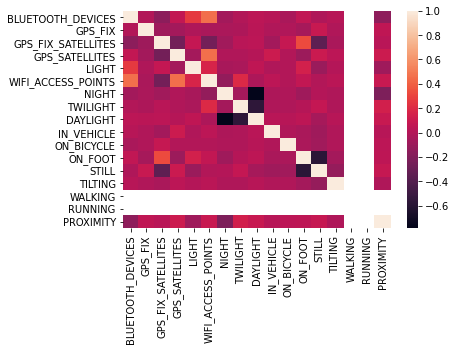

In [24]:
import seaborn as sns
corr = df.corr()
sns.heatmap(corr)

In [12]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.to_numpy(), target, test_size=0.33) 
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)


(22540, 17) (11103, 17) (22540,) (11103,)


In [14]:
D = X_train.shape[1]
D

17

In [28]:
# Now all the fun Tensorflow stuff
# Build the model

i = tf.keras.layers.Input(shape=(D,),name='Input')
n_i = tf.keras.layers.LayerNormalization(axis=-1,name='Normalization')(i[:,:6])
x = tf.keras.layers.Concatenate(name='Concatenate')([n_i,i[:,6:]])
x = tf.keras.layers.Dense(16,activation='sigmoid')(x)
x = tf.keras.layers.Dense(1, activation='sigmoid', name='Classifier')(x)
model = tf.keras.models.Model(i, x)


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

r = model.fit(X_train,y_train,validation_data=(X_test, y_test), epochs=200)

print("Train score:", model.evaluate(X_train, y_train))
print("Test score:", model.evaluate(X_test, y_test))


Epoch 1/200
705/705 [==============================] - 3s 3ms/step - loss: 0.6135 - accuracy: 0.6889 - val_loss: 0.4115 - val_accuracy: 0.8228
Epoch 2/200
705/705 [==============================] - 2s 3ms/step - loss: 0.3975 - accuracy: 0.8257 - val_loss: 0.3703 - val_accuracy: 0.8414
Epoch 3/200
705/705 [==============================] - 2s 3ms/step - loss: 0.3684 - accuracy: 0.8431 - val_loss: 0.3577 - val_accuracy: 0.8672
Epoch 4/200
705/705 [==============================] - 2s 3ms/step - loss: 0.3532 - accuracy: 0.8585 - val_loss: 0.3481 - val_accuracy: 0.8674
Epoch 5/200
705/705 [==============================] - 2s 3ms/step - loss: 0.3519 - accuracy: 0.8639 - val_loss: 0.3404 - val_accuracy: 0.8447
Epoch 6/200
705/705 [==============================] - 2s 3ms/step - loss: 0.3415 - accuracy: 0.8603 - val_loss: 0.3359 - val_accuracy: 0.8478
Epoch 7/200
705/705 [==============================] - 2s 3ms/step - loss: 0.3393 - accuracy: 0.8625 - val_loss: 0.3314 - val_accuracy: 0.8654

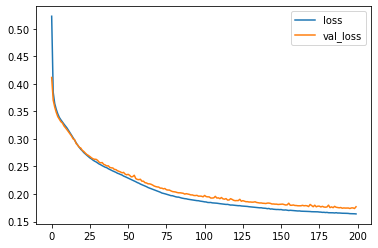

In [29]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

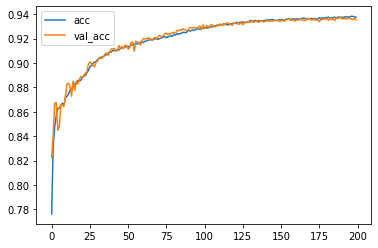

In [30]:
# Plot the accuracy too
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [31]:
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 17)]         0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_8 (Sli (None, 6)            0           Input[0][0]                      
__________________________________________________________________________________________________
Normalization (LayerNormalizati (None, 6)            12          tf.__operators__.getitem_8[0][0] 
__________________________________________________________________________________________________
tf.__operators__.getitem_9 (Sli (None, 11)           0           Input[0][0]                      
____________________________________________________________________________________________

In [ ]:
for z in zip(df_wide.columns.values,model.layers[5].get_weights()[0]):
  print(z)


('BLUETOOTH_DEVICES', array([0.78467166], dtype=float32))
('GPS_FIX_SATELLITES', array([-2.941558], dtype=float32))
('GPS_SATELLITES', array([0.3114541], dtype=float32))
('TMD3725_Light Ambient Light Sensor Non-wakeup', array([-0.46210802], dtype=float32))
('WIFI_ACCESS_POINTS', array([2.3207603], dtype=float32))
('IN_VEHICLE', array([-1.6584494], dtype=float32))
('ON_BICYCLE', array([-0.40118644], dtype=float32))
('ON_FOOT', array([-5.6376424], dtype=float32))
('STILL', array([1.7916169], dtype=float32))
('UNKOWN', array([1.2244202], dtype=float32))
('TILTING', array([0.3653815], dtype=float32))
('WALKING', array([-0.27648577], dtype=float32))
('RUNNING', array([0.12622678], dtype=float32))
('TMD3725_Proximity Proximity Sensor Wakeup', array([0.3069393], dtype=float32))


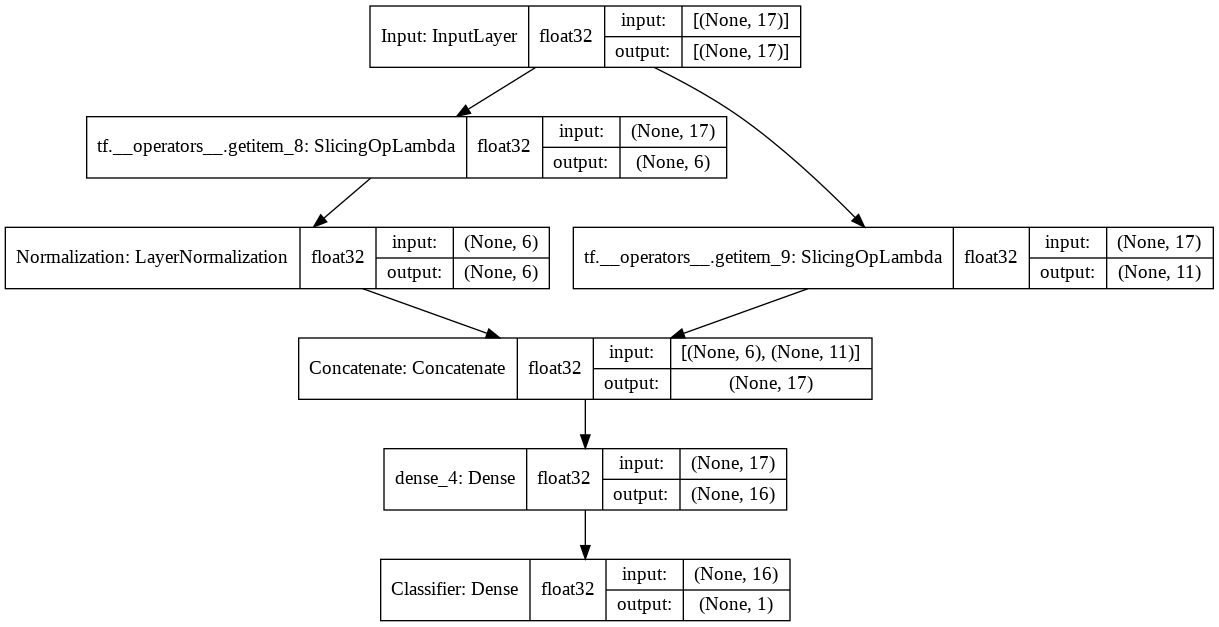

In [32]:
tf.keras.utils.plot_model(model,show_shapes=True,show_dtype=True, show_layer_names=True, expand_nested=True)

In [35]:
!pip install shap

     |████████████████████████████████| 358kB 8.2MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491622 sha256=9ce2ec94680da25be63d446cacaad1163874389635dd4daa845298df5757a2c9
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [36]:
import shap
# KernelExplainer is a general approach that can work with any ML framework
# Its inputs are the predictions and training data

# Summarize the training set to accelerate analysis
df_train_normed_summary = shap.kmeans(X_train, 25)

# Instantiate an explainer with the model predictions and training data summary
explainer = shap.KernelExplainer(model.predict, df_train_normed_summary)

# Extract Shapley values from the explainer
shap_values = explainer.shap_values(X_train)

KeyboardInterrupt: ignored

In [38]:
tf.saved_model.save(model, "saved_model_keras_dir")

converter.target_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.allow_custom_ops=True
converter.experimental_new_converter =True
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)


INFO:tensorflow:Assets written to: saved_model_keras_dir/assets


INFO:tensorflow:Assets written to: saved_model_keras_dir/assets


INFO:tensorflow:Assets written to: /tmp/tmpe660b2c8/assets


INFO:tensorflow:Assets written to: /tmp/tmpe660b2c8/assets


In [ ]:
shap.summary_plot(shap_values[0], df_train)